In [1]:
import numpy as np
import pandas as pd
import pyampute
from pyampute.ampute import MultivariateAmputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
import os
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing

In [60]:
from cycler import cycler
from scipy import optimize


colors = [ '#EDA98D', '#8DDCED' ,'#93ED8D', '#8D98ED', '#BFFBE2', '#FBBFDB', '#8598BC']
# Matplotlib style definition for saving plots
plot_style = {
    'axes.prop_cycle': cycler(
        'color',
        ['#1f17f4',
        '#ffa40e',
        '#ff3487',
        '#008b00',
        '#17becf',
        '#850085'
        ]
        ) + cycler('marker', ['o', 's', '^', 'v', 'D', 'd']),
    'axes.edgecolor': '0.3',
    'xtick.color': '0.3',
    'ytick.color': '0.3',
    'xtick.labelsize': '15',
    'ytick.labelsize': '15',
    'axes.labelcolor': 'black',
    'axes.grid': True,
    'grid.color': '#E68F6B',
    'grid.alpha': '0.8',
    'grid.linestyle': '--',
    'axes.labelsize':'20',
    'font.size': '15',
    'lines.linewidth': '1',
    'figure.figsize': '12, 6',
    'lines.markeredgewidth': '0',
    'lines.markersize': '2',
    'axes.spines.right': True,
    'axes.spines.top': True,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'savefig.dpi': '180'
    }

In [2]:
plt.style.use(None)#plot_style

TypeError: 'NoneType' object is not iterable

# Data generating

In [2]:
def data_gener(n, mu, ro):
    Sigma = np.array([[1, ro, ro], [ro, 1, ro], [ro, ro, 1]])
    X_cont = np.random.multivariate_normal(mu, Sigma, size = n)

    return X_cont

In [4]:
#     mu = np.array([1, 10, 100]) 
mu = np.array([1, 100, 10000])
# mu = np.array([5, 5, 10])
cor = 0.3
X_full = data_gener(1000, mu, cor)

In [113]:
a = pd.DataFrame(X_full, columns = ['Y1','Y2','X1'])
a

,Y1,Y2,X1
0,0.844802,98.808287,10000.195980
1,1.280780,99.879220,10000.154079
2,0.567525,98.717777,9998.939417
3,1.715040,100.522468,9998.821557
4,2.379116,101.087599,10000.638194
...,...,...,...
995,0.893770,100.456815,10000.408879
996,2.317303,101.790187,9999.956148
997,0.692244,102.024288,10000.183935
998,0.798534,100.614420,9998.558446


In [112]:
scaledX = StandardScaler().fit_transform(a)
scaledX  

array([[-0.16382733, -1.21382279,  0.21548738],
       [ 0.26127414, -0.12812343,  0.17374717],
       [-0.43418733, -1.30558118, -1.03626825],
       ...,
       [-0.31258004,  2.04652365,  0.20348843],
       [-0.20894123,  0.61721445, -1.41578148],
       [ 0.66397295, -0.04387208,  0.04260962]])

In [95]:
normalized_arr = preprocessing.normalize(a)

In [97]:
pd.DataFrame(normalized_arr, columns = ['Y1','Y2','X1'])

,Y1,Y2,X1
0,0.000208,0.010105,0.999949
1,0.000143,0.010057,0.999949
2,0.000296,0.009941,0.999951
3,0.000050,0.009928,0.999951
4,0.000302,0.010130,0.999949
...,...,...,...
995,0.000004,0.009923,0.999951
996,0.000114,0.009984,0.999950
997,0.000102,0.010083,0.999949
998,-0.000015,0.010063,0.999949


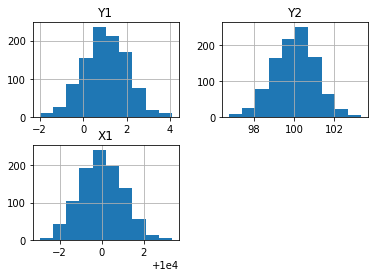

In [5]:
df = pd.DataFrame(X_full, columns = ['Y1','Y2','X1'])
df.hist()
plt.show()

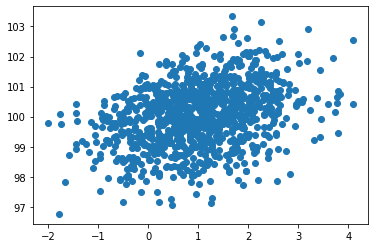

In [6]:
plt.plot(df['Y1'], df['Y2'], 'o')

In [17]:
ma = MultivariateAmputation(
    patterns = [ {'incomplete_vars': [0,1], 'mechanism': "MAR"} ],
    prop = 0.2
)
X_miss = ma.fit_transform(X_full)
tmp = pd.DataFrame(X_miss, columns = ['Y1','Y2','X1'])
tmp

,Y1,Y2,X1
0,4.847842,3.838749,10.761963
1,5.845318,6.452313,10.978453
2,5.435076,4.271631,11.153310
3,4.262760,5.786436,9.932504
4,3.234284,3.705036,9.803562
...,...,...,...
995,5.326082,3.452994,9.440944
996,NaN,NaN,10.676340
997,5.123768,4.733260,11.288897
998,5.154460,5.545659,10.543422


In [18]:
imp0 = IterativeImputer(max_iter=50, random_state = 0, estimator = BayesianRidge()).fit_transform(tmp)
pd.DataFrame(imp0, columns = ['Y1','Y2','X1'])

,Y1,Y2,X1
0,4.847842,3.838749,10.761963
1,5.845318,6.452313,10.978453
2,5.435076,4.271631,11.153310
3,4.262760,5.786436,9.932504
4,3.234284,3.705036,9.803562
...,...,...,...
995,5.326082,3.452994,9.440944
996,5.166642,5.118475,10.676340
997,5.123768,4.733260,11.288897
998,5.154460,5.545659,10.543422


In [19]:
imp00 = IterativeImputer(max_iter=50, random_state = 0, estimator = BayesianRidge()).fit_transform(tmp)
pd.DataFrame(imp00, columns = ['Y1','Y2','X1'])

,Y1,Y2,X1
0,4.847842,3.838749,10.761963
1,5.845318,6.452313,10.978453
2,5.435076,4.271631,11.153310
3,4.262760,5.786436,9.932504
4,3.234284,3.705036,9.803562
...,...,...,...
995,5.326082,3.452994,9.440944
996,5.166642,5.118475,10.676340
997,5.123768,4.733260,11.288897
998,5.154460,5.545659,10.543422


# Iterative Imputer with different random_state

IterativeImputer моделирует каждую переменную с пропущенными значениями как функцию по остальным переменным и эту оценку использует для вменения. он делает это циклически: на каждом шаге столбец с пропуском обозначается как output y, а остальные столбцы обрабатываются как imputs X. Регрессор учится (настраивается) на (X, y) на известных значениях y. Далее регрессор испольхуется для заполнения пропущенныx значений y. Выполняется для каждой переменной итеративно и далее процедура повторяется max_iter кругов. Возвращаются результаты последнего круга.

estimator = BayesianRidge().

Байесовская регрессия позволяет механизму выжить при недостаточных или плохо распределенных данных. Предполагается, что ответ «y» получен из распределения вероятностей, а не оценивается как одно значение.

## random_state = 0

In [20]:
imp1 = IterativeImputer(random_state = 0, estimator = BayesianRidge(), sample_posterior=True).fit_transform(tmp)
pd.DataFrame(imp1, columns = ['Y1','Y2','X1'])

,Y1,Y2,X1
0,4.847842,3.838749,10.761963
1,5.845318,6.452313,10.978453
2,5.435076,4.271631,11.153310
3,4.262760,5.786436,9.932504
4,3.234284,3.705036,9.803562
...,...,...,...
995,5.326082,3.452994,9.440944
996,6.074912,5.146174,10.676340
997,5.123768,4.733260,11.288897
998,5.154460,5.545659,10.543422


In [21]:
imp12 = IterativeImputer(random_state = 0, estimator = BayesianRidge(), sample_posterior=True).fit_transform(tmp)
pd.DataFrame(imp12, columns = ['Y1','Y2','X1'])

,Y1,Y2,X1
0,4.847842,3.838749,10.761963
1,5.845318,6.452313,10.978453
2,5.435076,4.271631,11.153310
3,4.262760,5.786436,9.932504
4,3.234284,3.705036,9.803562
...,...,...,...
995,5.326082,3.452994,9.440944
996,6.074912,5.146174,10.676340
997,5.123768,4.733260,11.288897
998,5.154460,5.545659,10.543422


Распределение не успело сойтись к стационарному:

In [31]:
imp11 = IterativeImputer(max_iter = 1, random_state = 0, estimator = BayesianRidge(), sample_posterior=True).fit_transform(tmp)
pd.DataFrame(imp11, columns = ['Y1','Y2','X1'])

,Y1,Y2,X1
0,5.134357,4.193066,8.157442
1,5.400585,4.481869,11.037301
2,4.706784,6.750529,8.677442
3,5.718540,4.058763,8.962720
4,5.711573,7.023019,10.650826
...,...,...,...
995,6.253514,5.204777,10.001674
996,5.019831,5.494325,9.920008
997,5.299057,4.316922,9.997319
998,7.088330,5.348311,11.436592


## random_state = 9

In [23]:
imp2 = IterativeImputer(random_state = 9, estimator = BayesianRidge(), sample_posterior = True).fit_transform(tmp)
pd.DataFrame(imp2, columns = ['Y1','Y2','X1'])

,Y1,Y2,X1
0,5.134357,4.193066,8.157442
1,6.515501,4.727593,11.037301
2,4.706784,6.750529,8.677442
3,5.718540,4.058763,8.962720
4,5.466623,5.717746,10.650826
...,...,...,...
995,6.253514,5.204777,10.001674
996,5.019831,5.494325,9.920008
997,5.299057,4.316922,9.997319
998,7.088330,5.348311,11.436592


In [24]:
tmp_sum = (imp2 - imp1).sum()
tmp_sum

-27.85733956109795

# icee

In [4]:
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.preprocessing import StandardScaler

In [19]:
def ice_imp_TR(mu, param, num, propor, mech):

    corrs = np.arange(0.1, 1, 0.1)

    df_bias = pd.DataFrame(columns = ['full', mech+str(1), mech+str(2), mech+str(3), mech+str(4)])

    for cor in corrs:

        n = 0
        df_means = pd.DataFrame(columns = ['mean_full', 'mean_M1', 'mean_M2', 'mean_M3', 'mean_M4'])

        for n in np.arange(25):

            a = data_gener(1000, mu, cor)
            aa = pd.DataFrame(a, columns = ['Y1','Y2','X1'])
#             X_full = preprocessing.normalize(aa)
            X_full = StandardScaler().fit_transform(aa)
            df_means.loc[n, 'mean_full'] = X_full[:,num].mean() 
            
             
            
            
 


            #___MAR1________'incomplete_vars': [0,1], 'weights': [0,0,1]

            ma = MultivariateAmputation(
                patterns = [ {'incomplete_vars': [0,1], 'mechanism': mech} ],
                prop = propor
            )
            X_miss = ma.fit_transform(X_full)
            
            imp = IterativeImputer(random_state = n, estimator = BayesianRidge(), sample_posterior = True).fit_transform(X_miss)
            df_means.loc[n, 'mean_M1'] = imp[:,num].mean()


            
            #___MAR2________'incomplete_vars': [0], 'weights': [0,1,1]

            ma = MultivariateAmputation(
                patterns = [ {'incomplete_vars': [0], 'mechanism': mech} ],
                prop = propor
            )
            X_miss = ma.fit_transform(X_full)

            imp = IterativeImputer(random_state = n, estimator = BayesianRidge(), sample_posterior = True).fit_transform(X_miss)
            df_means.loc[n, 'mean_M2'] = imp[:,num].mean()




            #___MAR3________'incomplete_vars': [1,2], 'weights': [1,0,0]

            ma = MultivariateAmputation(
                patterns = [ {'incomplete_vars': [1,2], 'mechanism': mech} ],
                prop = propor
            )
            X_miss = ma.fit_transform(X_full)

            imp = IterativeImputer(random_state = n, estimator = BayesianRidge(), sample_posterior = True).fit_transform(X_miss)
            df_means.loc[n, 'mean_M3'] = imp[:,num].mean()



            
            #___MAR4________'incomplete_vars': [2], 'weights': [1,1,0]

            ma = MultivariateAmputation(
                patterns = [ {'incomplete_vars': [2], 'mechanism': mech} ],
                prop = propor
            )
            X_miss = ma.fit_transform(X_full)

            imp = IterativeImputer(random_state = n, estimator = BayesianRidge(), sample_posterior = True).fit_transform(X_miss)
            df_means.loc[n, 'mean_M4'] = imp[:,num].mean()


        df_bias.loc[cor, 'full'] = df_means['mean_full'].mean() - df_means['mean_full'].mean() 
        df_bias.loc[cor, mech+str(1)] = df_means['mean_M1'].mean() - df_means['mean_full'].mean()
        df_bias.loc[cor, mech+str(2)] = df_means['mean_M2'].mean() - df_means['mean_full'].mean()
        df_bias.loc[cor, mech+str(3)] = df_means['mean_M3'].mean() - df_means['mean_full'].mean()
        df_bias.loc[cor, mech+str(4)] = df_means['mean_M4'].mean() - df_means['mean_full'].mean()

    return df_bias

In [20]:
mu_X_1 = np.array([5, 5, 10])
mu_X_11 = np.array([1, 5, 10])
mu_X_2 = np.array([1, 100, 10000])
mu_X_3 = np.array([1, 10000, 100000000])

In [81]:
%%time
mu = mu_X_11

mu11_icelr_MAR_Y1_50_300 = ice_imp_lr(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MAR")
mu11_icelr_MAR_Y2_50_300 = ice_imp_lr(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MAR")
mu11_icelr_MAR_X1_50_300 = ice_imp_lr(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MAR")
mu11_icelr_MNAR_Y1_50_300 = ice_imp_lr(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MNAR")
mu11_icelr_MNAR_Y2_50_300 = ice_imp_lr(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MNAR")
mu11_icelr_MNAR_X1_50_300 = ice_imp_lr(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MNAR")

CPU times: user 13min 40s, sys: 3.84 s, total: 13min 44s
Wall time: 13min 46s


<AxesSubplot:title={'center':'by X1, MNAR'}>

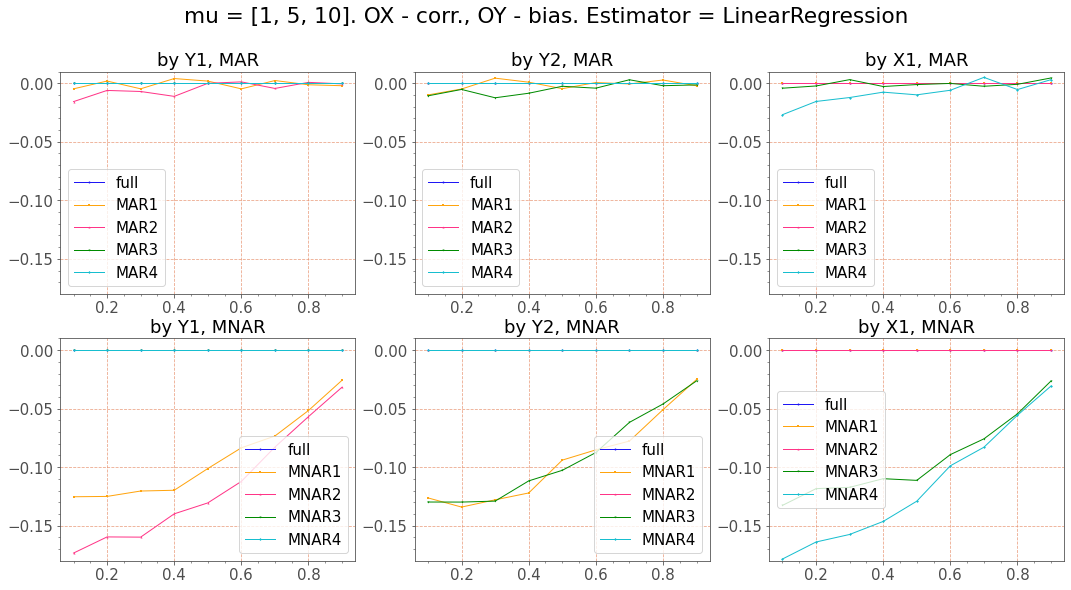

In [82]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6*3,3 * 3))
[ax.set_ylim([-0.18, 0.01]) for ax in axes.flatten()]
fig.suptitle("mu = [1, 5, 10]. OX - corr., OY - bias. Estimator = LinearRegression", fontsize="x-large")

mu11_icelr_MAR_Y1_50_300.plot(ax = axes[0,0], title = "by Y1, MAR")
mu11_icelr_MNAR_Y1_50_300.plot(ax = axes[1,0], title = "by Y1, MNAR")
mu11_icelr_MAR_Y2_50_300.plot(ax = axes[0,1], title = "by Y2, MAR")
mu11_icelr_MNAR_Y2_50_300.plot(ax = axes[1,1], title = "by Y2, MNAR")
mu11_icelr_MAR_X1_50_300.plot(ax = axes[0,2], title = "by X1, MAR")
mu11_icelr_MNAR_X1_50_300.plot(ax = axes[1,2], title = "by X1, MNAR")

# results

In [16]:
%%time
mu = mu_X_1

mu1_ice_TR_MAR_Y1_50_1000 = ice_imp_TR(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MAR")
mu1_ice_TR_MAR_Y2_50_1000 = ice_imp_TR(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MAR")
mu1_ice_TR_MAR_X1_50_1000 = ice_imp_TR(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MAR")
mu1_ice_TR_MNAR_Y1_50_1000 = ice_imp_TR(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MNAR")
mu1_ice_TR_MNAR_Y2_50_1000 = ice_imp_TR(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MNAR")
mu1_ice_TR_MNAR_X1_50_1000 = ice_imp_TR(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MNAR")

CPU times: user 36min 16s, sys: 5.92 s, total: 36min 22s
Wall time: 45min 47s


<AxesSubplot:title={'center':'by X1, MNAR'}>

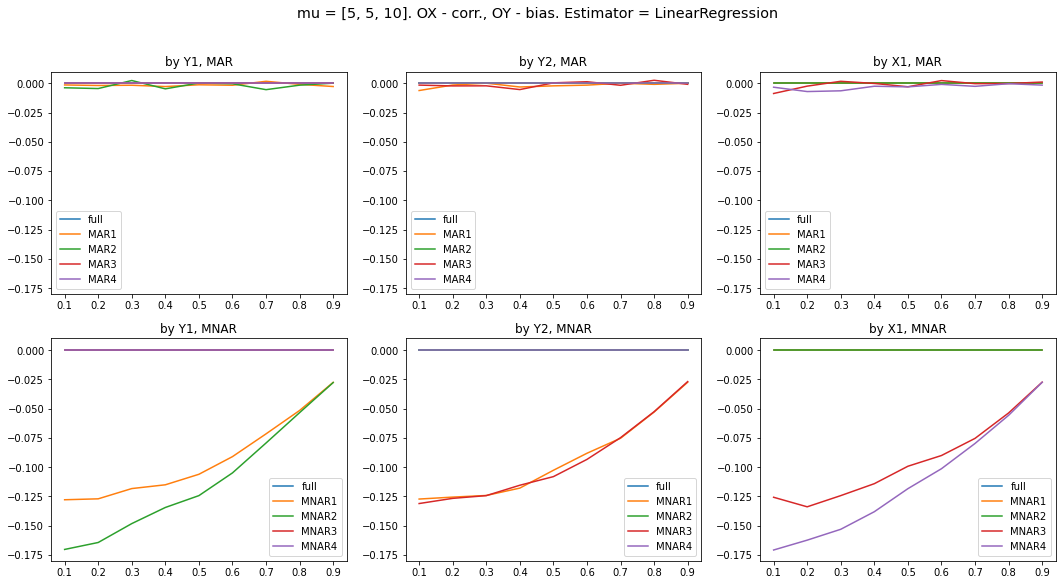

In [18]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6*3,3 * 3))
[ax.set_ylim([-0.18, 0.01]) for ax in axes.flatten()]
fig.suptitle("mu = [5, 5, 10]. OX - corr., OY - bias. Estimator = LinearRegression", fontsize="x-large")

mu1_ice_TR_MAR_Y1_50_1000.plot(ax = axes[0,0], title = "by Y1, MAR")
mu1_ice_TR_MNAR_Y1_50_1000.plot(ax = axes[1,0], title = "by Y1, MNAR")
mu1_ice_TR_MAR_Y2_50_1000.plot(ax = axes[0,1], title = "by Y2, MAR")
mu1_ice_TR_MNAR_Y2_50_1000.plot(ax = axes[1,1], title = "by Y2, MNAR")
mu1_ice_TR_MAR_X1_50_1000.plot(ax = axes[0,2], title = "by X1, MAR")
mu1_ice_TR_MNAR_X1_50_1000.plot(ax = axes[1,2], title = "by X1, MNAR")

In [21]:
%%time
mu = mu_X_2

mu2_ice_TR_MAR_Y1_25_1000_scaled = ice_imp_TR(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MAR")
mu2_ice_TR_MAR_Y2_25_1000_scaled = ice_imp_TR(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MAR")
mu2_ice_TR_MAR_X1_25_1000_scaled = ice_imp_TR(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MAR")
mu2_ice_TR_MNAR_Y1_25_1000_scaled = ice_imp_TR(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MNAR")
mu2_ice_TR_MNAR_Y2_25_1000_scaled = ice_imp_TR(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MNAR")
mu2_ice_TR_MNAR_X1_25_1000_scaled = ice_imp_TR(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MNAR")

CPU times: user 18min 29s, sys: 4.94 s, total: 18min 34s
Wall time: 18min 37s


<AxesSubplot:title={'center':'by X1, MNAR'}>

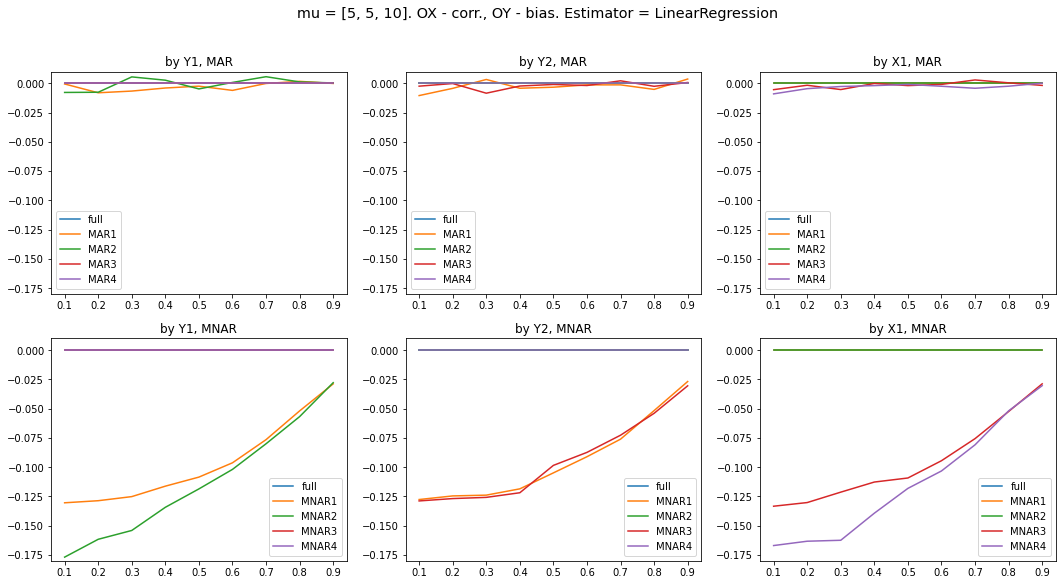

In [22]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6*3,3 * 3))
[ax.set_ylim([-0.18, 0.01]) for ax in axes.flatten()]
fig.suptitle("mu = [5, 5, 10]. OX - corr., OY - bias. Estimator = LinearRegression", fontsize="x-large")

mu2_ice_TR_MAR_Y1_25_1000_scaled.plot(ax = axes[0,0], title = "by Y1, MAR")
mu2_ice_TR_MNAR_Y1_25_1000_scaled.plot(ax = axes[1,0], title = "by Y1, MNAR")
mu2_ice_TR_MAR_Y2_25_1000_scaled.plot(ax = axes[0,1], title = "by Y2, MAR")
mu2_ice_TR_MNAR_Y2_25_1000_scaled.plot(ax = axes[1,1], title = "by Y2, MNAR")
mu2_ice_TR_MAR_X1_25_1000_scaled.plot(ax = axes[0,2], title = "by X1, MAR")
mu2_ice_TR_MNAR_X1_25_1000_scaled.plot(ax = axes[1,2], title = "by X1, MNAR")

prop = 0.4

In [23]:
%%time
mu = mu_X_2

mu22_ice_TR_MAR_Y1_25_1000_scaled = ice_imp_TR(mu = mu, param = "Y1", num = 0, propor = 0.4, mech = "MAR")
mu22_ice_TR_MAR_Y2_25_1000_scaled = ice_imp_TR(mu = mu, param = "Y2", num = 1, propor = 0.4, mech = "MAR")
mu22_ice_TR_MAR_X1_25_1000_scaled = ice_imp_TR(mu = mu, param = "X1", num = 2, propor = 0.4, mech = "MAR")
mu22_ice_TR_MNAR_Y1_25_1000_scaled = ice_imp_TR(mu = mu, param = "Y1", num = 0, propor = 0.4, mech = "MNAR")
mu22_ice_TR_MNAR_Y2_25_1000_scaled = ice_imp_TR(mu = mu, param = "Y2", num = 1, propor = 0.4, mech = "MNAR")
mu22_ice_TR_MNAR_X1_25_1000_scaled = ice_imp_TR(mu = mu, param = "X1", num = 2, propor = 0.4, mech = "MNAR")

CPU times: user 33min 11s, sys: 9.1 s, total: 33min 20s
Wall time: 33min 24s


<AxesSubplot:title={'center':'by X1, MNAR'}>

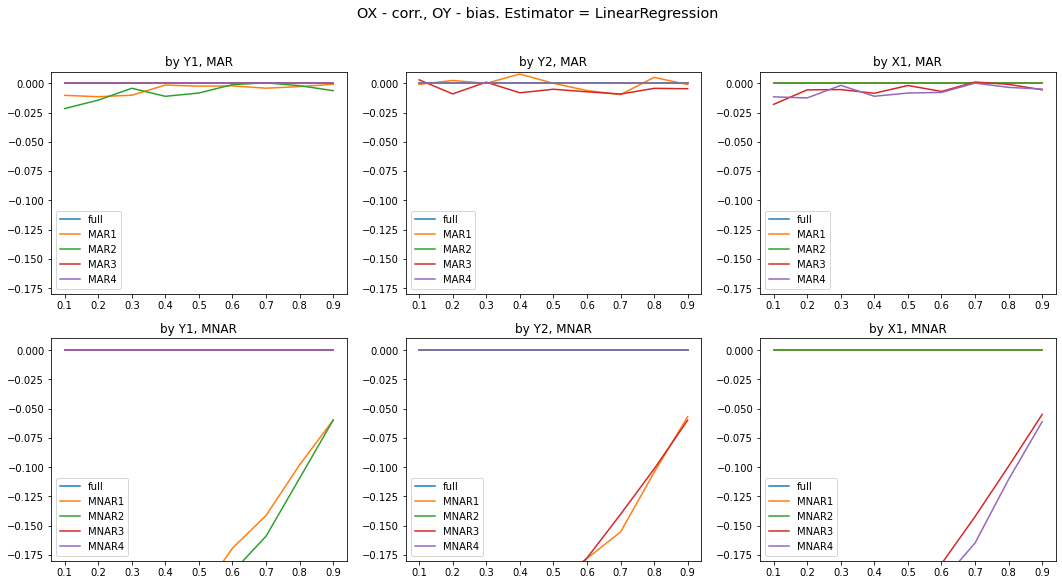

In [24]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6*3,3 * 3))
[ax.set_ylim([-0.18, 0.01]) for ax in axes.flatten()]
fig.suptitle("OX - corr., OY - bias. Estimator = LinearRegression", fontsize="x-large")

mu22_ice_TR_MAR_Y1_25_1000_scaled.plot(ax = axes[0,0], title = "by Y1, MAR")
mu22_ice_TR_MNAR_Y1_25_1000_scaled.plot(ax = axes[1,0], title = "by Y1, MNAR")
mu22_ice_TR_MAR_Y2_25_1000_scaled.plot(ax = axes[0,1], title = "by Y2, MAR")
mu22_ice_TR_MNAR_Y2_25_1000_scaled.plot(ax = axes[1,1], title = "by Y2, MNAR")
mu22_ice_TR_MAR_X1_25_1000_scaled.plot(ax = axes[0,2], title = "by X1, MAR")
mu22_ice_TR_MNAR_X1_25_1000_scaled.plot(ax = axes[1,2], title = "by X1, MNAR")

In [84]:
%%time
mu = np.array([1, 5, 25])

mu0_icelr_MAR_Y1_50_300 = ice_imp_lr(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MAR")
mu0_icelr_MAR_Y2_50_300 = ice_imp_lr(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MAR")
mu0_icelr_MAR_X1_50_300 = ice_imp_lr(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MAR")
mu0_icelr_MNAR_Y1_50_300 = ice_imp_lr(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MNAR")
mu0_icelr_MNAR_Y2_50_300 = ice_imp_lr(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MNAR")
mu0_icelr_MNAR_X1_50_300 = ice_imp_lr(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MNAR")

CPU times: user 13min 29s, sys: 3.81 s, total: 13min 33s
Wall time: 13min 33s


<AxesSubplot:title={'center':'by X1, MNAR'}>

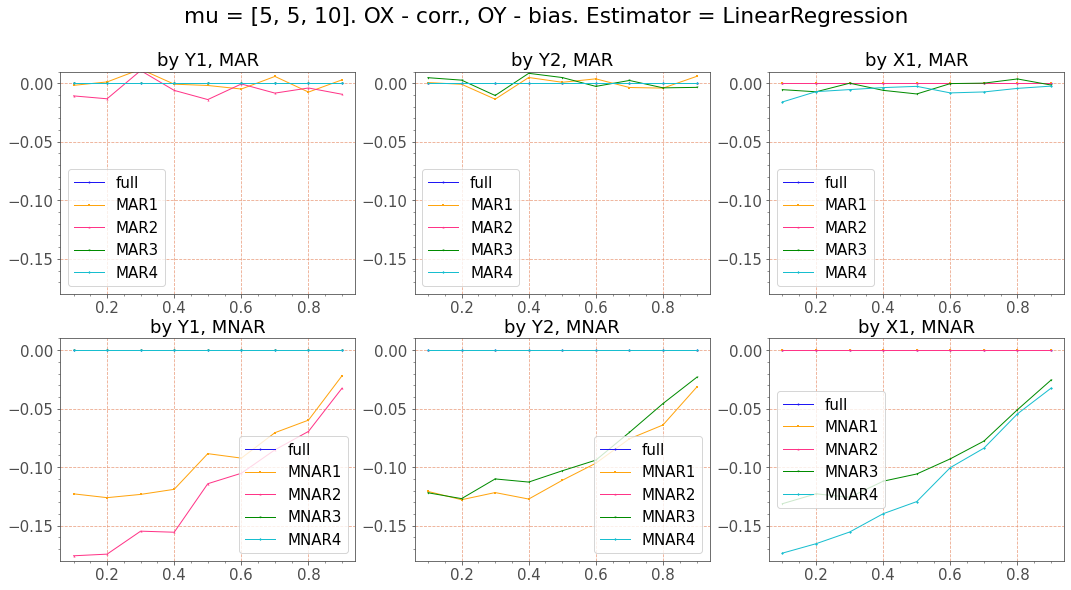

In [86]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6*3,3 * 3))
[ax.set_ylim([-0.18, 0.01]) for ax in axes.flatten()]
fig.suptitle("mu = [5, 5, 10]. OX - corr., OY - bias. Estimator = LinearRegression", fontsize="x-large")

mu0_icelr_MAR_Y1_50_300.plot(ax = axes[0,0], title = "by Y1, MAR")
mu0_icelr_MNAR_Y1_50_300.plot(ax = axes[1,0], title = "by Y1, MNAR")
mu0_icelr_MAR_Y2_50_300.plot(ax = axes[0,1], title = "by Y2, MAR")
mu0_icelr_MNAR_Y2_50_300.plot(ax = axes[1,1], title = "by Y2, MNAR")
mu0_icelr_MAR_X1_50_300.plot(ax = axes[0,2], title = "by X1, MAR")
mu0_icelr_MNAR_X1_50_300.plot(ax = axes[1,2], title = "by X1, MNAR")

In [117]:
%%time
mu = mu_X_2

# mu2_icelr_MAR_Y1_50_300 = ice_imp_lr(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MAR")
# mu2_icelr_MAR_Y2_50_300 = ice_imp_lr(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MAR")
# mu2_icelr_MAR_X1_50_300 = ice_imp_lr(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MAR")
# mu2_icelr_MNAR_Y1_50_300 = ice_imp_lr(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MNAR")
# mu2_icelr_MNAR_Y2_50_300 = ice_imp_lr(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MNAR")
mu2_icelr_MNAR_X1_50_300 = ice_imp_lr(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MNAR")

CPU times: user 5min 37s, sys: 746 ms, total: 5min 38s
Wall time: 5min 38s


<AxesSubplot:title={'center':'by X1, MNAR'}>

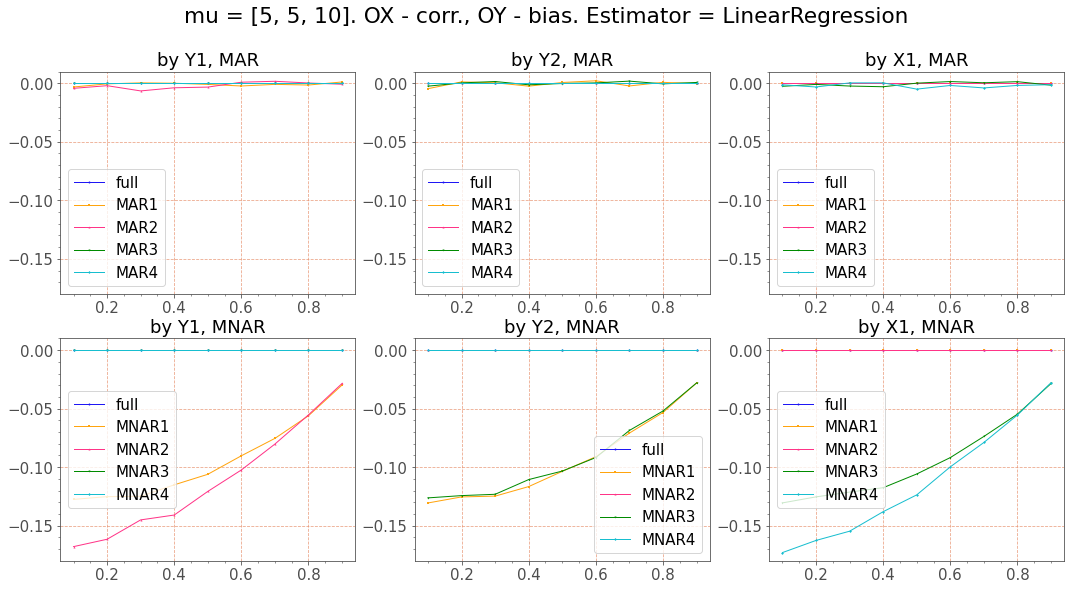

In [118]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6*3,3 * 3))
[ax.set_ylim([-0.18, 0.01]) for ax in axes.flatten()]
fig.suptitle("mu = [5, 5, 10]. OX - corr., OY - bias. Estimator = LinearRegression", fontsize="x-large")

mu2_icelr_MAR_Y1_50_300.plot(ax = axes[0,0], title = "by Y1, MAR")
mu2_icelr_MNAR_Y1_50_300.plot(ax = axes[1,0], title = "by Y1, MNAR")
mu2_icelr_MAR_Y2_50_300.plot(ax = axes[0,1], title = "by Y2, MAR")
mu2_icelr_MNAR_Y2_50_300.plot(ax = axes[1,1], title = "by Y2, MNAR")
mu2_icelr_MAR_X1_50_300.plot(ax = axes[0,2], title = "by X1, MAR")
mu2_icelr_MNAR_X1_50_300.plot(ax = axes[1,2], title = "by X1, MNAR")

In [7]:
%%time
mu = mu_X_3

mu3_icelr_MAR_Y1_50_300 = ice_imp_lr(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MAR")
mu3_icelr_MAR_Y2_50_300 = ice_imp_lr(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MAR")
mu3_icelr_MAR_X1_50_300 = ice_imp_lr(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MAR")

NameError: name 'mu_X_3' is not defined

In [129]:
mu3_icelr_MNAR_X1_50_300

,full,MNAR1,MNAR2,MNAR3,MNAR4
0.1,0.0,0.0,0.0,-0.124384,-0.172522
0.2,0.0,0.0,0.0,-0.122617,-0.167686
0.3,0.0,0.0,0.0,-0.117106,-0.151734
0.4,0.0,0.0,0.0,-0.113062,-0.138561
0.5,0.0,0.0,0.0,-0.104602,-0.122137
0.6,0.0,0.0,0.0,-0.088701,-0.101774
0.7,0.0,0.0,0.0,-0.074544,-0.079749
0.8,0.0,0.0,0.0,-0.048943,-0.054859
0.9,0.0,0.0,0.0,-0.025544,-0.026378


<AxesSubplot:title={'center':'by X1, MNAR'}>

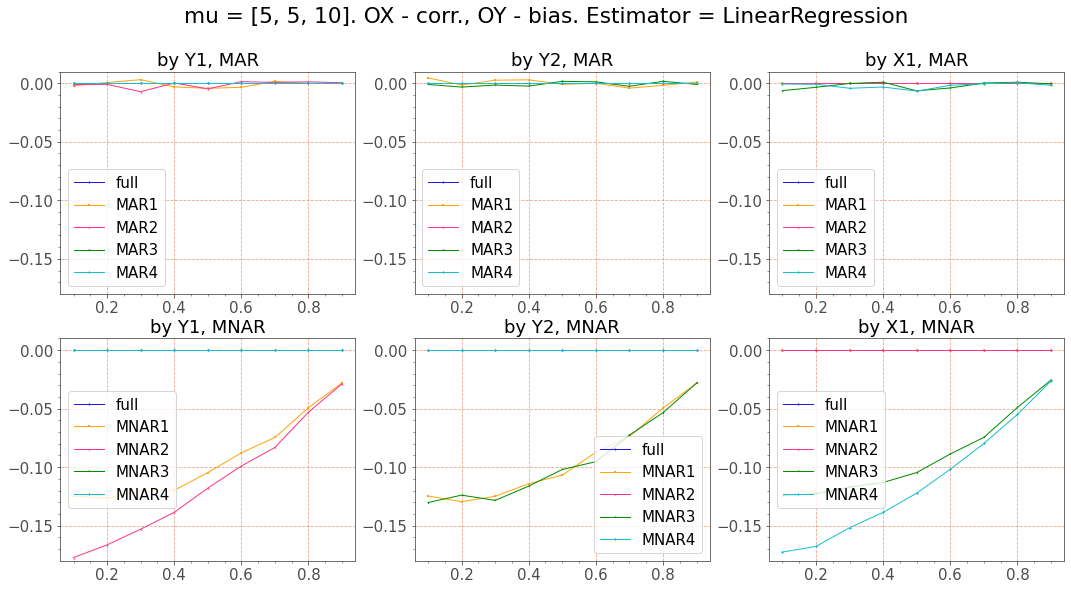

In [122]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6*3,3 * 3))
[ax.set_ylim([-0.18, 0.01]) for ax in axes.flatten()]
fig.suptitle("mu = [5, 5, 10]. OX - corr., OY - bias. Estimator = LinearRegression", fontsize="x-large")

mu3_icelr_MAR_Y1_50_300.plot(ax = axes[0,0], title = "by Y1, MAR")
mu3_icelr_MNAR_Y1_50_300.plot(ax = axes[1,0], title = "by Y1, MNAR")
mu3_icelr_MAR_Y2_50_300.plot(ax = axes[0,1], title = "by Y2, MAR")
mu3_icelr_MNAR_Y2_50_300.plot(ax = axes[1,1], title = "by Y2, MNAR")
mu3_icelr_MAR_X1_50_300.plot(ax = axes[0,2], title = "by X1, MAR")
mu3_icelr_MNAR_X1_50_300.plot(ax = axes[1,2], title = "by X1, MNAR")

In [8]:
mu_X_1 = np.array([5, 5, 10])
mu_X_2 = np.array([1, 100, 10000])
mu_X_3 = np.array([1, 10000, 100000000])

In [9]:
%%time
mu = mu_X_3

mu33_icelr_MNAR_Y1_50_300 = ice_imp_lr(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MNAR")
mu33_icelr_MNAR_Y2_50_300 = ice_imp_lr(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MNAR")
mu33_icelr_MNAR_X1_50_300 = ice_imp_lr(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MNAR")

CPU times: user 17min 14s, sys: 5.31 s, total: 17min 19s
Wall time: 17min 19s


<AxesSubplot:title={'center':'by X1, MNAR'}>

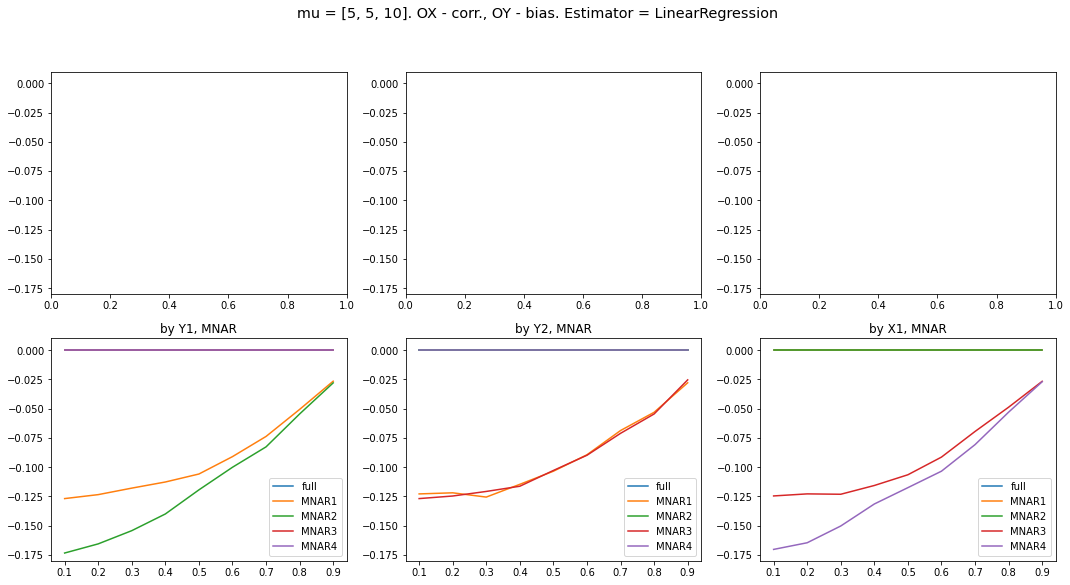

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6*3,3 * 3))
[ax.set_ylim([-0.18, 0.01]) for ax in axes.flatten()]
fig.suptitle("mu = [5, 5, 10]. OX - corr., OY - bias. Estimator = LinearRegression", fontsize="x-large")

# mu33_icelr_MAR_Y1_50_300.plot(ax = axes[0,0], title = "by Y1, MAR")
mu33_icelr_MNAR_Y1_50_300.plot(ax = axes[1,0], title = "by Y1, MNAR")
# mu33_icelr_MAR_Y2_50_300.plot(ax = axes[0,1], title = "by Y2, MAR")
mu33_icelr_MNAR_Y2_50_300.plot(ax = axes[1,1], title = "by Y2, MNAR")
# mu33_icelr_MAR_X1_50_300.plot(ax = axes[0,2], title = "by X1, MAR")
mu33_icelr_MNAR_X1_50_300.plot(ax = axes[1,2], title = "by X1, MNAR")

<AxesSubplot:title={'center':'by X1, MNAR'}>

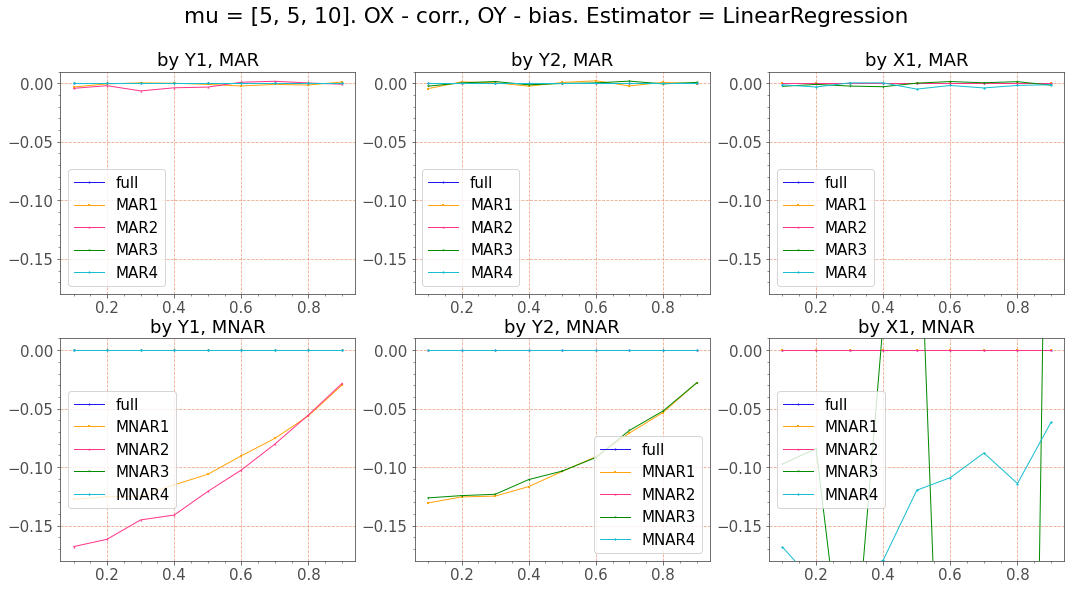

In [116]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6*3,3 * 3))
[ax.set_ylim([-0.18, 0.01]) for ax in axes.flatten()]
fig.suptitle("mu = [5, 5, 10]. OX - corr., OY - bias. Estimator = LinearRegression", fontsize="x-large")

mu2_icelr_MAR_Y1_50_300.plot(ax = axes[0,0], title = "by Y1, MAR")
mu2_icelr_MNAR_Y1_50_300.plot(ax = axes[1,0], title = "by Y1, MNAR")
mu2_icelr_MAR_Y2_50_300.plot(ax = axes[0,1], title = "by Y2, MAR")
mu2_icelr_MNAR_Y2_50_300.plot(ax = axes[1,1], title = "by Y2, MNAR")
mu2_icelr_MAR_X1_50_300.plot(ax = axes[0,2], title = "by X1, MAR")
mu2_icelr_MNAR_X1_50_300.plot(ax = axes[1,2], title = "by X1, MNAR")

<AxesSubplot:title={'center':'by X1, MNAR'}>

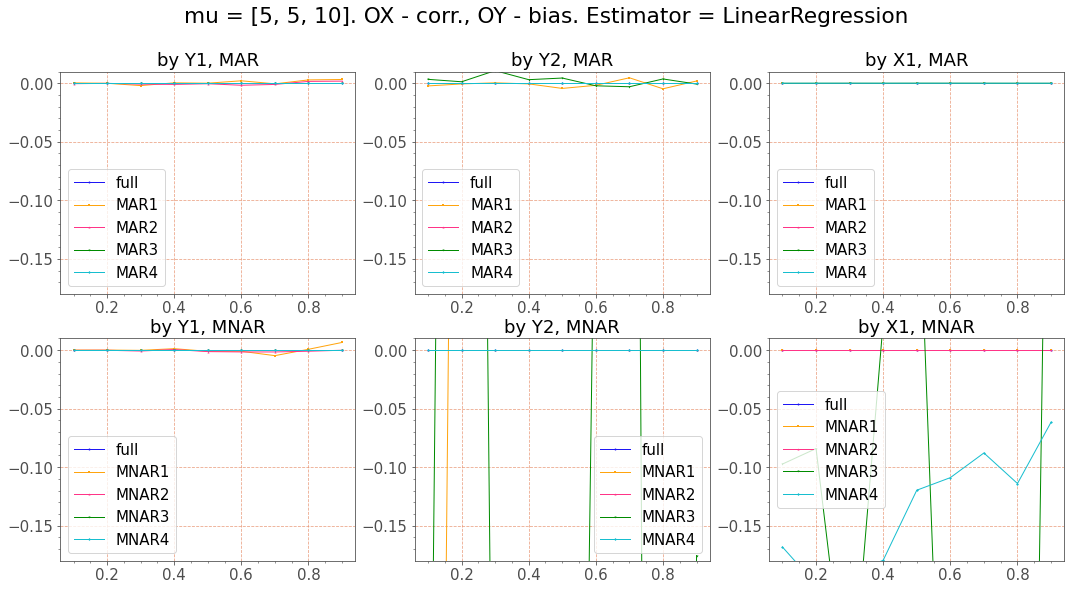

In [106]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6*3,3 * 3))
[ax.set_ylim([-0.18, 0.01]) for ax in axes.flatten()]
fig.suptitle("mu = [5, 5, 10]. OX - corr., OY - bias. Estimator = LinearRegression", fontsize="x-large")

mu2_icelr_MAR_Y1_50_300.plot(ax = axes[0,0], title = "by Y1, MAR")
mu2_icelr_MNAR_Y1_50_300.plot(ax = axes[1,0], title = "by Y1, MNAR")
mu2_icelr_MAR_Y2_50_300.plot(ax = axes[0,1], title = "by Y2, MAR")
mu2_icelr_MNAR_Y2_50_300.plot(ax = axes[1,1], title = "by Y2, MNAR")
mu2_icelr_MAR_X1_50_300.plot(ax = axes[0,2], title = "by X1, MAR")
mu2_icelr_MNAR_X1_50_300.plot(ax = axes[1,2], title = "by X1, MNAR")

<AxesSubplot:title={'center':'by X1, MNAR'}>

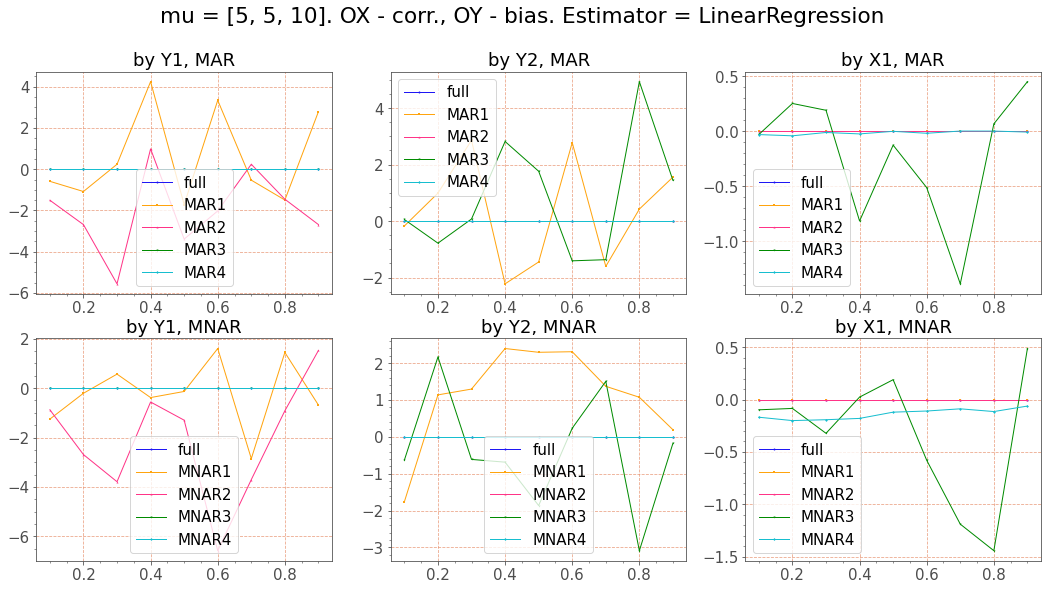

In [78]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6*3,3 * 3))
# [ax.set_ylim([-0.18, 0.01]) for ax in axes.flatten()]
fig.suptitle("mu = [5, 5, 10]. OX - corr., OY - bias. Estimator = LinearRegression", fontsize="x-large")

mu2_icelr_MAR_Y1_50_300.plot(ax = axes[0,0], title = "by Y1, MAR")
mu2_icelr_MNAR_Y1_50_300.plot(ax = axes[1,0], title = "by Y1, MNAR")
mu2_icelr_MAR_Y2_50_300.plot(ax = axes[0,1], title = "by Y2, MAR")
mu2_icelr_MNAR_Y2_50_300.plot(ax = axes[1,1], title = "by Y2, MNAR")
mu2_icelr_MAR_X1_50_300.plot(ax = axes[0,2], title = "by X1, MAR")
mu2_icelr_MNAR_X1_50_300.plot(ax = axes[1,2], title = "by X1, MNAR")

In [40]:
%%time
mu = mu_X_1

mu1_icelr_MAR_Y1_100_300 = ice_imp_lr(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MAR")
mu1_icelr_MAR_Y2_100_300 = ice_imp_lr(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MAR")
mu1_icelr_MAR_X1_100_300 = ice_imp_lr(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MAR")
mu1_icelr_MNAR_Y1_100_300 = ice_imp_lr(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MNAR")
mu1_icelr_MNAR_Y2_100_300 = ice_imp_lr(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MNAR")
mu1_icelr_MNAR_X1_100_300 = ice_imp_lr(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MNAR")

CPU times: user 26min 58s, sys: 5.92 s, total: 27min 4s
Wall time: 27min 5s


<AxesSubplot:title={'center':'by X1, MNAR'}>

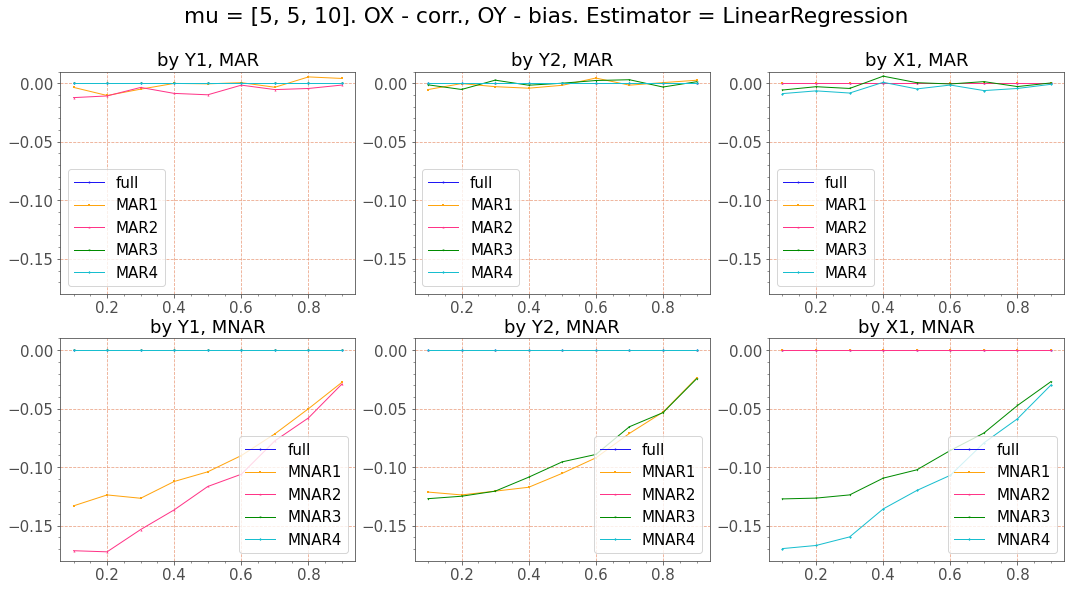

In [75]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6*3,3 * 3))
[ax.set_ylim([-0.18, 0.01]) for ax in axes.flatten()]
fig.suptitle("mu = [5, 5, 10]. OX - corr., OY - bias. Estimator = LinearRegression", fontsize="x-large")

mu1_icelr_MAR_Y1_100_300.plot(ax = axes[0,0], title = "by Y1, MAR")
mu1_icelr_MNAR_Y1_100_300.plot(ax = axes[1,0], title = "by Y1, MNAR")
mu1_icelr_MAR_Y2_100_300.plot(ax = axes[0,1], title = "by Y2, MAR")
mu1_icelr_MNAR_Y2_100_300.plot(ax = axes[1,1], title = "by Y2, MNAR")
mu1_icelr_MAR_X1_100_300.plot(ax = axes[0,2], title = "by X1, MAR")
mu1_icelr_MNAR_X1_100_300.plot(ax = axes[1,2], title = "by X1, MNAR")